# Setup

In [19]:
%pip install --upgrade pip -q
%pip install pandas scikit-learn imbalanced-learn scikit-optimize sklearn-genetic-opt matplotlib seaborn -q 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [43]:
import os
import zipfile
import pandas as pd 
import numpy as np
import time
import traceback
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import clone
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score
from sklearn.neural_network import MLPClassifier
from skopt import BayesSearchCV  
from skopt.space import Categorical as SkoptCategorical
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical as GeneticCategorical
from imblearn.over_sampling import SMOTE

In [3]:
path_dataset = 'dataset'
path_dataset_zip = f'{path_dataset}/german.zip'
path_dataset_extracted = f'{path_dataset}/german'
path_dataset_file = f'{path_dataset_extracted}/german.data-numeric'
path_result_csv = 'result.csv'

In [4]:
os.makedirs(path_dataset, exist_ok=True)
if not os.path.exists(path_dataset_zip):
  !curl https://archive.ics.uci.edu/static/public/144/statlog+german+credit+data.zip -o {path_dataset_zip}
zipfile.ZipFile(path_dataset_zip).extractall(path_dataset_extracted)

In [5]:
df = pd.read_csv(path_dataset_file, header=None, sep='\s+')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2


# Pré processamento dos dados

In [54]:
# Vamos substituir os autlieres, por seus valores dos quartis (Nome do método: Winsorization)
X, y = df.iloc[:, :-1], df.iloc[:, -1]

X = X.copy()
for col in X.columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X[col] = np.where(X[col] < lower_bound, Q1, X[col])
    X[col] = np.where(X[col] > upper_bound, Q3, X[col])

X_scalered = RobustScaler().fit_transform(X)
df.isnull().sum().sum()

np.int64(0)

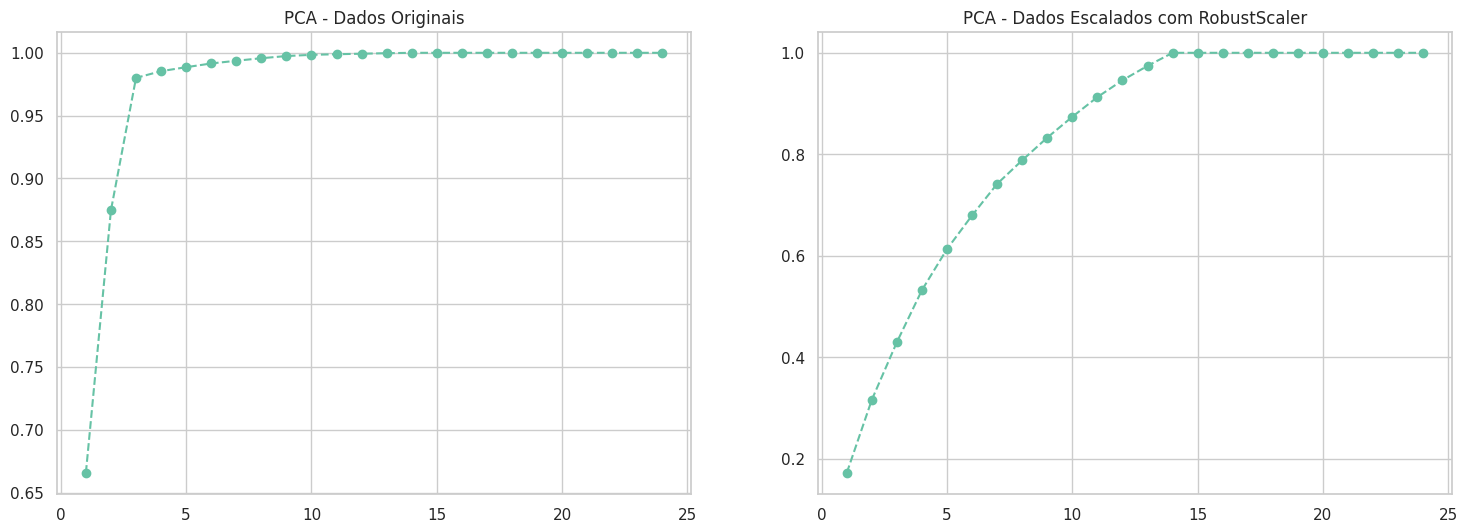

In [ ]:
PCA_normal = PCA().fit(X)
PCA_scalered = PCA().fit(X_scalered)

explained_variance_ratio = PCA_normal.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

explained_variance_ratio_scaled = PCA_scalered.explained_variance_ratio_
cumulative_explained_variance_scaled = np.cumsum(explained_variance_ratio_scaled)

fig, ax = plt.subplots(figsize=(18, 6), ncols=2, nrows=1)

ax[0].plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--');
ax[0].set_title('PCA - Dados Originais')
ax[1].plot(range(1, len(cumulative_explained_variance_scaled) + 1), cumulative_explained_variance_scaled, marker='o', linestyle='--');
ax[1].set_title('PCA - Dados Escalados com RobustScaler')

In [56]:
X_pca = PCA(n_components=3).fit_transform(X)
X_pca.shape

(1000, 3)

# Configuração dos experimentos

In [8]:


class MLPWrapper(MLPClassifier):
    def fit(self, X, y):
        if isinstance(self.hidden_layer_sizes, str):
            self.hidden_layer_sizes = ast.literal_eval(self.hidden_layer_sizes)
        return super().fit(X, y)

param_grids = {
    'RF': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
        # 3 * 4 * 3 * 2 = 72 combinações
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
        # 5 * 2 * 2 = 20 combinações
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto']
        # 4 * 3 * 2 = 24 combinações
    },
    'MLP': {
        'hidden_layer_sizes': ['(50,)', '(100,)', '(50, 50)'],
        'activation': ['tanh', 'relu'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant', 'adaptive']
        # 3 * 2 * 2 * 2 = 24 combinações
    }
}

def rodar_experimento(algoritmo_nome, modelo_base, params, X, y):
    lista_folds_detalhado = [] 
    lista_resumo_final = []
    
    smote = SMOTE(random_state=42)
    n_splits = 5
    estrategias = ['GridSearch', 'RandomSearch', 'Bayesiana', 'Genetica']
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    x_train, x_test, y_train, y_test = np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

    for estrategia in estrategias:
        print(f"\t> Rodando {algoritmo_nome} com {estrategia}...")
        opt = None
        
        if estrategia == 'GridSearch':
            opt = GridSearchCV(modelo_base, params, cv=cv, scoring='f1', refit=True, n_jobs=-1)
        elif estrategia == 'RandomSearch':
            opt = RandomizedSearchCV(modelo_base, params, n_iter=10, cv=cv, scoring='f1', refit=True, n_jobs=-1, random_state=42)
        elif estrategia == 'Bayesiana':
            params_copy = params.copy()
            if algoritmo_nome == 'MLP': 
                for key in params_copy: params_copy[key] = SkoptCategorical(params_copy[key])
            opt = BayesSearchCV(modelo_base, params_copy, n_iter=10, cv=cv, scoring='f1', refit=True, n_jobs=-1, random_state=42)
        elif estrategia == 'Genetica':
            params_copy = params.copy()
            for key in params_copy: params_copy[key] = GeneticCategorical(params_copy[key])
            opt = GASearchCV(estimator=modelo_base, param_grid=params_copy, population_size=10, generations=5, cv=cv, scoring='f1', refit=True, n_jobs=-1, verbose=0)
            
        try:
            print(f"\t\t> Iniciando Otimização...")
            x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
            start_time = time.time()
            opt.fit(x_train_smote, y_train_smote)
            final_time = time.time() - start_time
            best_params = opt.best_params_
            print(f"\t\t\t> Otimização concluída em {round(final_time, 2)} segundos.")
            
            y_test_pred = opt.best_estimator_.predict(x_test)
            y_test_proba = opt.best_estimator_.predict_proba(x_test)[:, 1]
            
            resumo_final = {
                'Algoritmo': algoritmo_nome,
                'Otimizador': estrategia,
                'Tempo_Total_s': round(final_time, 2),
                'Melhores_Params': str(best_params),
                'TEST_Accuracy': accuracy_score(y_test, y_test_pred),
                'TEST_F1': f1_score(y_test, y_test_pred),
                'TEST_Recall': recall_score(y_test, y_test_pred),
                'TEST_Precision': precision_score(y_test, y_test_pred),
                'TEST_AUC': roc_auc_score(y_test, y_test_proba)
            }
            lista_resumo_final.append(resumo_final)
            
            fold_idx = 1
            for train_ix, val_ix in cv.split(x_train, y_train):
                print(f"\t\t> Processando Fold {fold_idx}...")
                
                X_fold_train, X_fold_val = x_train[train_ix], x_train[val_ix]
                y_fold_train, y_fold_val = y_train[train_ix], y_train[val_ix]
                X_fold_train_res, y_fold_train_res = smote.fit_resample(X_fold_train, y_fold_train)
            
                model_fold = clone(modelo_base)
                model_fold.set_params(**best_params)
                inicio = time.time()
                model_fold.fit(X_fold_train_res, y_fold_train_res)
                fim = time.time()
                
                y_val_pred = model_fold.predict(X_fold_val)
                y_val_proba = model_fold.predict_proba(X_fold_val)[:, 1]
                roc_auc = roc_auc_score(y_fold_val, y_val_proba)
                
                metrics_fold = {
                    'Algoritmo': algoritmo_nome,
                    'Otimizador': estrategia,
                    'Fold_ID': fold_idx,
                    'Tempo_Treinamento_s': round(fim - inicio, 2),
                    'CV_Accuracy': accuracy_score(y_fold_val, y_val_pred),
                    'CV_Precision': precision_score(y_fold_val, y_val_pred),
                    'CV_Recall': recall_score(y_fold_val, y_val_pred),
                    'CV_F1': f1_score(y_fold_val, y_val_pred),
                    'CV_ROC_AUC': roc_auc,
                    'CV_Kappa': cohen_kappa_score(y_fold_val, y_val_pred),  
                }
                lista_folds_detalhado.append(metrics_fold)
                fold_idx += 1
                print(f"\t\t\t> Fold {fold_idx-1} processado em {round(fim - inicio, 2)} segundos.")

        except Exception as e:
            print(f"ERRO CRÍTICO em {algoritmo_nome} - {estrategia}: {e}")
            traceback.print_exc()
            
    return pd.DataFrame(lista_folds_detalhado), pd.DataFrame(lista_resumo_final)

# Cenários de Classificação 

In [9]:
todos_resumos = []
todos_folds = []

modelos = [
    ('MLP', MLPWrapper(max_iter=100_000, random_state=42)),
    ('RF', RandomForestClassifier(random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC(max_iter=100_000,probability=True, random_state=42)), 
]

for tipo in ['PCA', 'Original']:
    for nome_algo, modelo in modelos:
        print(f"\n>> Processando {nome_algo} cenário {tipo}...")
        df_folds, df_resumo = rodar_experimento(
            nome_algo, 
            modelo, 
            param_grids[nome_algo], 
            X_scalered if tipo == 'Original' else X_pca,
            y
        )
        
        df_resumo['Cenario'] = tipo
        todos_resumos.append(df_resumo)
        df_folds['Cenario'] = tipo
        todos_folds.append(df_folds)


>> Processando MLP cenário PCA...
	> Rodando MLP com GridSearch...
		> Iniciando Otimização...
			> Otimização concluída em 51.0 segundos.
		> Processando Fold 1...
			> Fold 1 processado em 14.46 segundos.
		> Processando Fold 2...
			> Fold 2 processado em 13.65 segundos.
		> Processando Fold 3...
			> Fold 3 processado em 1.29 segundos.
		> Processando Fold 4...
			> Fold 4 processado em 0.95 segundos.
		> Processando Fold 5...
			> Fold 5 processado em 2.36 segundos.
	> Rodando MLP com RandomSearch...
		> Iniciando Otimização...
			> Otimização concluída em 45.1 segundos.
		> Processando Fold 1...
			> Fold 1 processado em 12.86 segundos.
		> Processando Fold 2...
			> Fold 2 processado em 13.6 segundos.
		> Processando Fold 3...
			> Fold 3 processado em 1.45 segundos.
		> Processando Fold 4...
			> Fold 4 processado em 0.84 segundos.
		> Processando Fold 5...
			> Fold 5 processado em 2.03 segundos.
	> Rodando MLP com Bayesiana...
		> Iniciando Otimização...
			> Otimização conc

In [10]:
df_resultados_resumo = pd.concat(todos_resumos, ignore_index=True)
df_resultados_resumo.to_csv('result_resumo.csv', index=False)
df_resultados_folds = pd.concat(todos_folds, ignore_index=True)
df_resultados_folds.to_csv('result_folds.csv', index=False)

In [21]:
df_resultados_resumo = pd.read_csv('result_resumo.csv')
df_resultados_folds = pd.read_csv('result_folds.csv')

In [22]:
df_summary = df_resultados_folds.groupby(['Algoritmo', 'Otimizador', 'Cenario']).agg({
    'CV_Accuracy': ['mean', 'std'],
    'CV_Precision': ['mean', 'std'],
    'CV_Recall': ['mean', 'std'],
    'CV_F1': ['mean', 'std'],
    'CV_ROC_AUC': ['mean', 'std'],
}).reset_index()
df_summary

Algoritmo    Otimizador   Cenario CV_Accuracy           CV_Precision  \
                                            mean       std         mean   
0        KNN     Bayesiana  Original     0.68000  0.030746     0.796074   
1        KNN     Bayesiana       PCA     0.61000  0.020059     0.759780   
2        KNN      Genetica  Original     0.68000  0.030746     0.796074   
3        KNN      Genetica       PCA     0.61000  0.020059     0.759780   
4        KNN    GridSearch  Original     0.68000  0.030746     0.796074   
5        KNN    GridSearch       PCA     0.61000  0.020059     0.759780   
6        KNN  RandomSearch  Original     0.68000  0.030746     0.796074   
7        KNN  RandomSearch       PCA     0.61000  0.020059     0.759780   
8        MLP     Bayesiana  Original     0.71750  0.033773     0.797018   
9        MLP     Bayesiana       PCA     0.62875  0.034967     0.779456   
10       MLP      Genetica  Original     0.73250  0.024367     0.812545   
11       MLP      Genetica       PCA     0.63500  0.030491     0.789547   
12       MLP    GridSearch  Original     0.73250  0.024367     0.812545   
13       MLP    GridSearch       PCA     0.63500  0.030491     0.789547   
14       MLP  RandomSearch  Original     0.73250  0.024367     0.812545   
15       MLP  RandomSearch       PCA     0.63500  0.030491     0.789547   
16        RF     Bayesiana  Original     0.75000  0.043750     0.797201   
17        RF     Bayesiana       PCA     0.65500  0.046435     0.769131   
18        RF      Genetica  Original     0.75125  0.038881     0.797393   
19        RF      Genetica       PCA     0.65500  0.046435     0.769131   
20        RF    GridSearch  Original     0.75125  0.038881     0.797393   
21        RF    GridSearch       PCA     0.65875  0.040889     0.769425   
22        RF  RandomSearch  Original     0.75000  0.043750     0.797201   
23        RF  RandomSearch       PCA     0.65875  0.040889     0.769425   
24       SVM     Bayesiana  Original     0.72625  0.028777     0.819144   
25       SVM     Bayesiana       PCA     0.60625  0.030936     0.801549   
26       SVM      Genetica  Original     0.72250  0.026737     0.808600   
27       SVM      Genetica       PCA     0.64750  0.021920     0.817410   
28       SVM    GridSearch  Original     0.72250  0.026737     0.808600   
29       SVM    GridSearch       PCA     0.64750  0.021920     0.817410   
30       SVM  RandomSearch  Original     0.70750  0.032295     0.790856   
31       SVM  RandomSearch       PCA     0.65000  0.022097     0.815346   

             CV_Recall               CV_F1           CV_ROC_AUC            
         std      mean       std      mean       std       mean       std  
0   0.025748  0.730357  0.031819  0.761506  0.023757   0.685138  0.060596  
1   0.019935  0.648214  0.025723  0.699285  0.017419   0.612798  0.036096  
2   0.025748  0.730357  0.031819  0.761506  0.023757   0.685138  0.060596  
3   0.019935  0.648214  0.025723  0.699285  0.017419   0.612798  0.036096  
4   0.025748  0.730357  0.031819  0.761506  0.023757   0.685138  0.060596  
5   0.019935  0.648214  0.025723  0.699285  0.017419   0.612798  0.036096  
6   0.025748  0.730357  0.031819  0.761506  0.023757   0.685138  0.060596  
7   0.019935  0.648214  0.025723  0.699285  0.017419   0.612798  0.036096  
8   0.046958  0.805357  0.034810  0.799891  0.019483   0.730208  0.055697  
9   0.047023  0.658929  0.038091  0.712969  0.025646   0.655766  0.059350  
10  0.031399  0.805357  0.034233  0.808176  0.017208   0.744196  0.038963  
11  0.039838  0.655357  0.035490  0.715259  0.023501   0.658073  0.059088  
12  0.031399  0.805357  0.034233  0.808176  0.017208   0.744196  0.038963  
13  0.039838  0.655357  0.035490  0.715259  0.023501   0.658073  0.059088  
14  0.031399  0.805357  0.034233  0.808176  0.017208   0.744196  0.038963  
15  0.039838  0.655357  0.035490  0.715259  0.023501   0.658073  0.059088  
16  0.039279  0.864286  0.014671  0.829150  0.026871   0.779948  0.041220  
17  0.03

# Plotagem

In [23]:
sns.set_theme(style="whitegrid", context='notebook', palette='Set2')

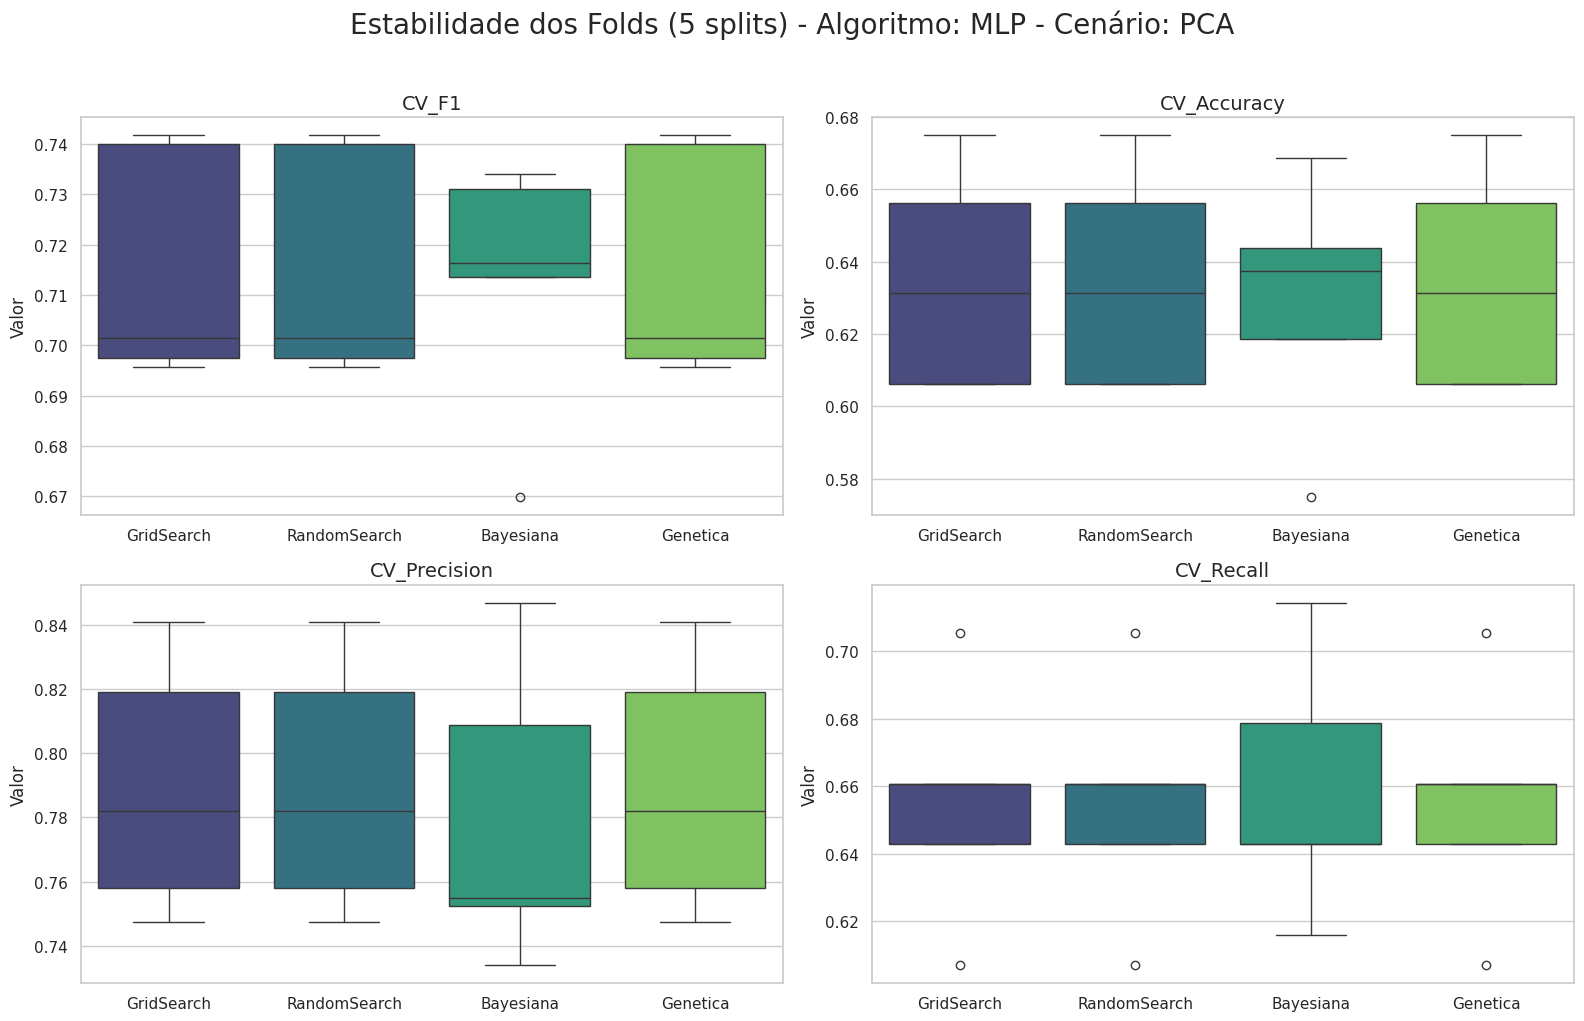

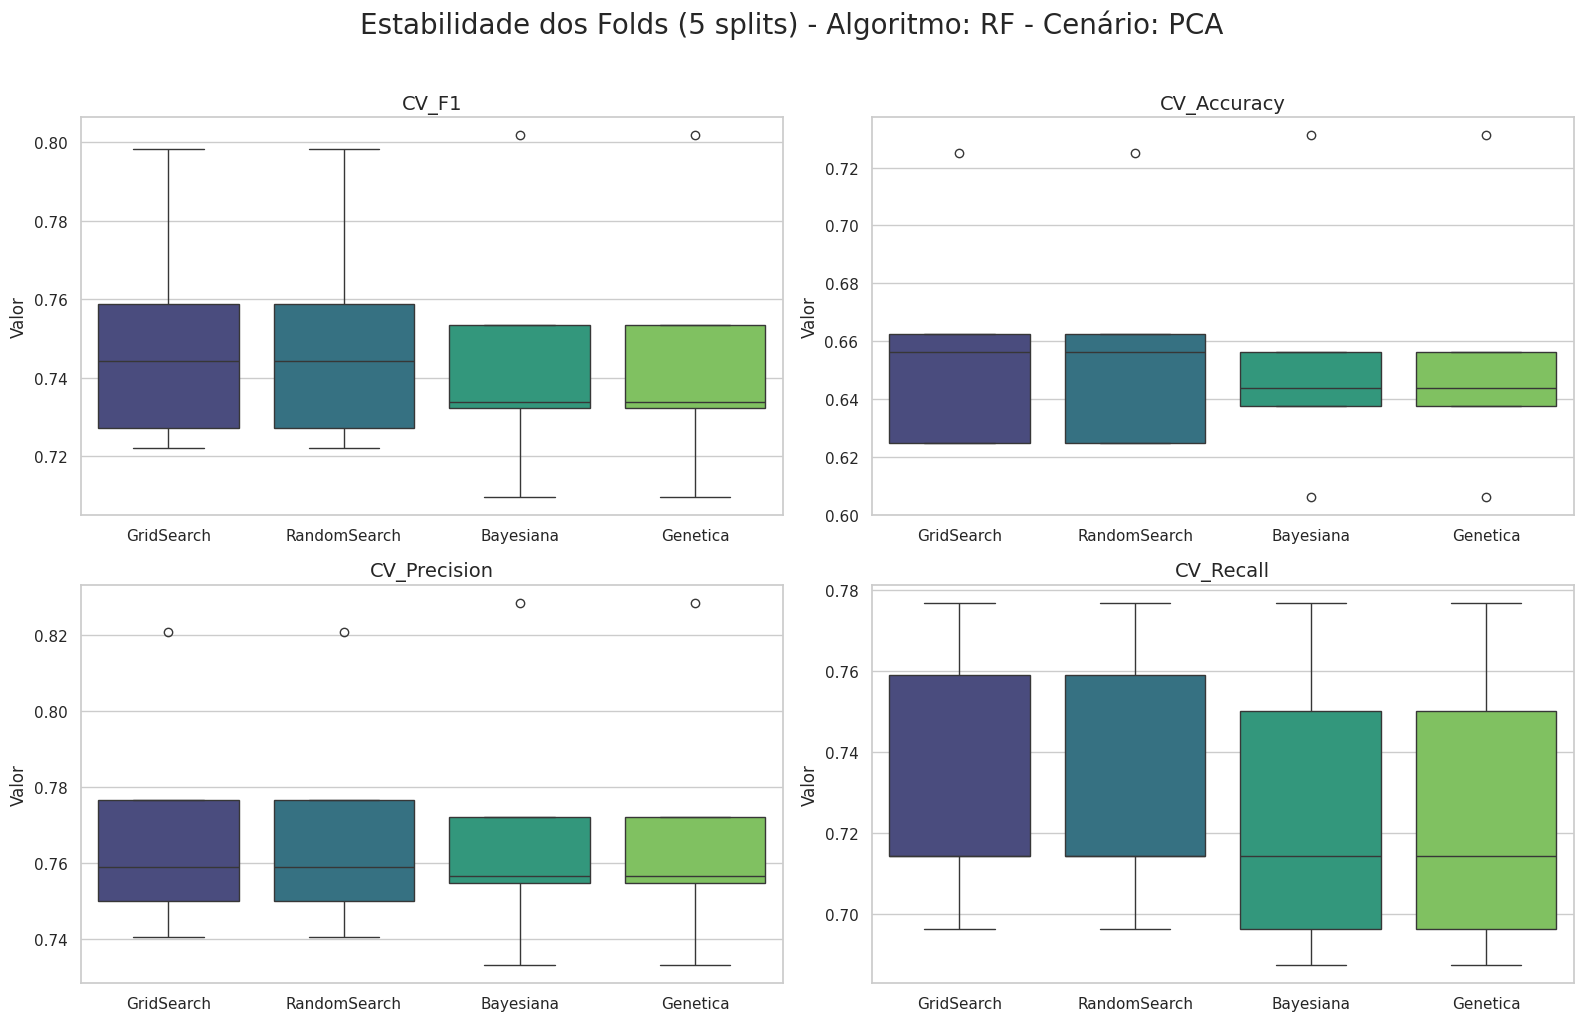

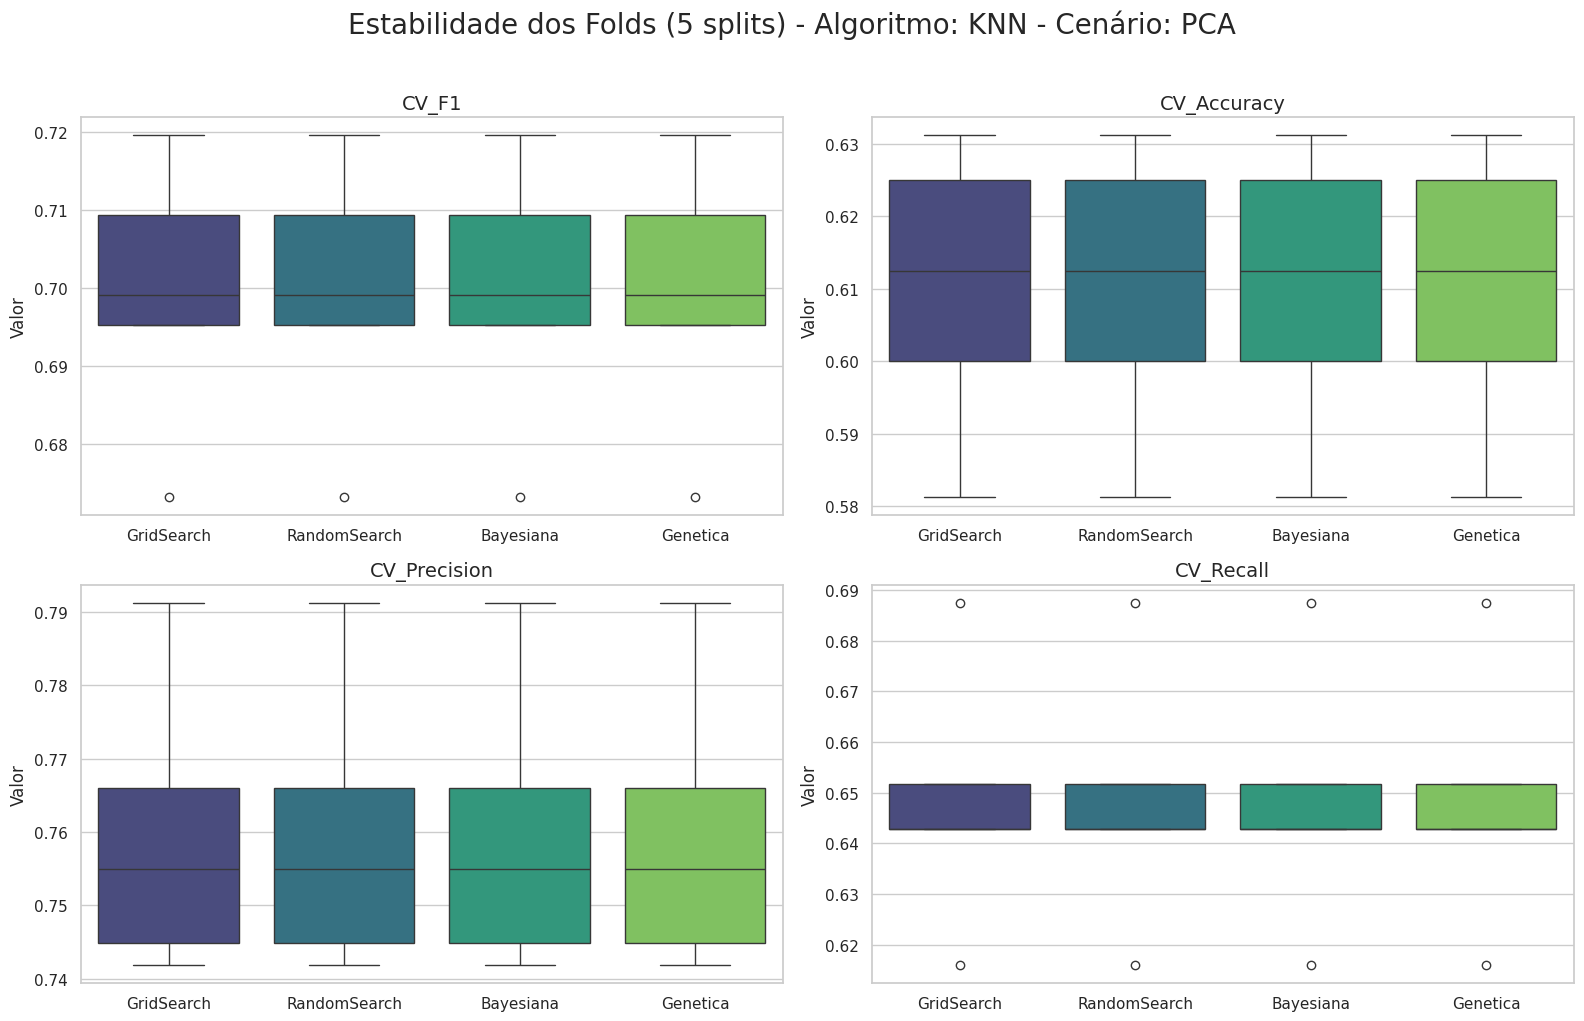

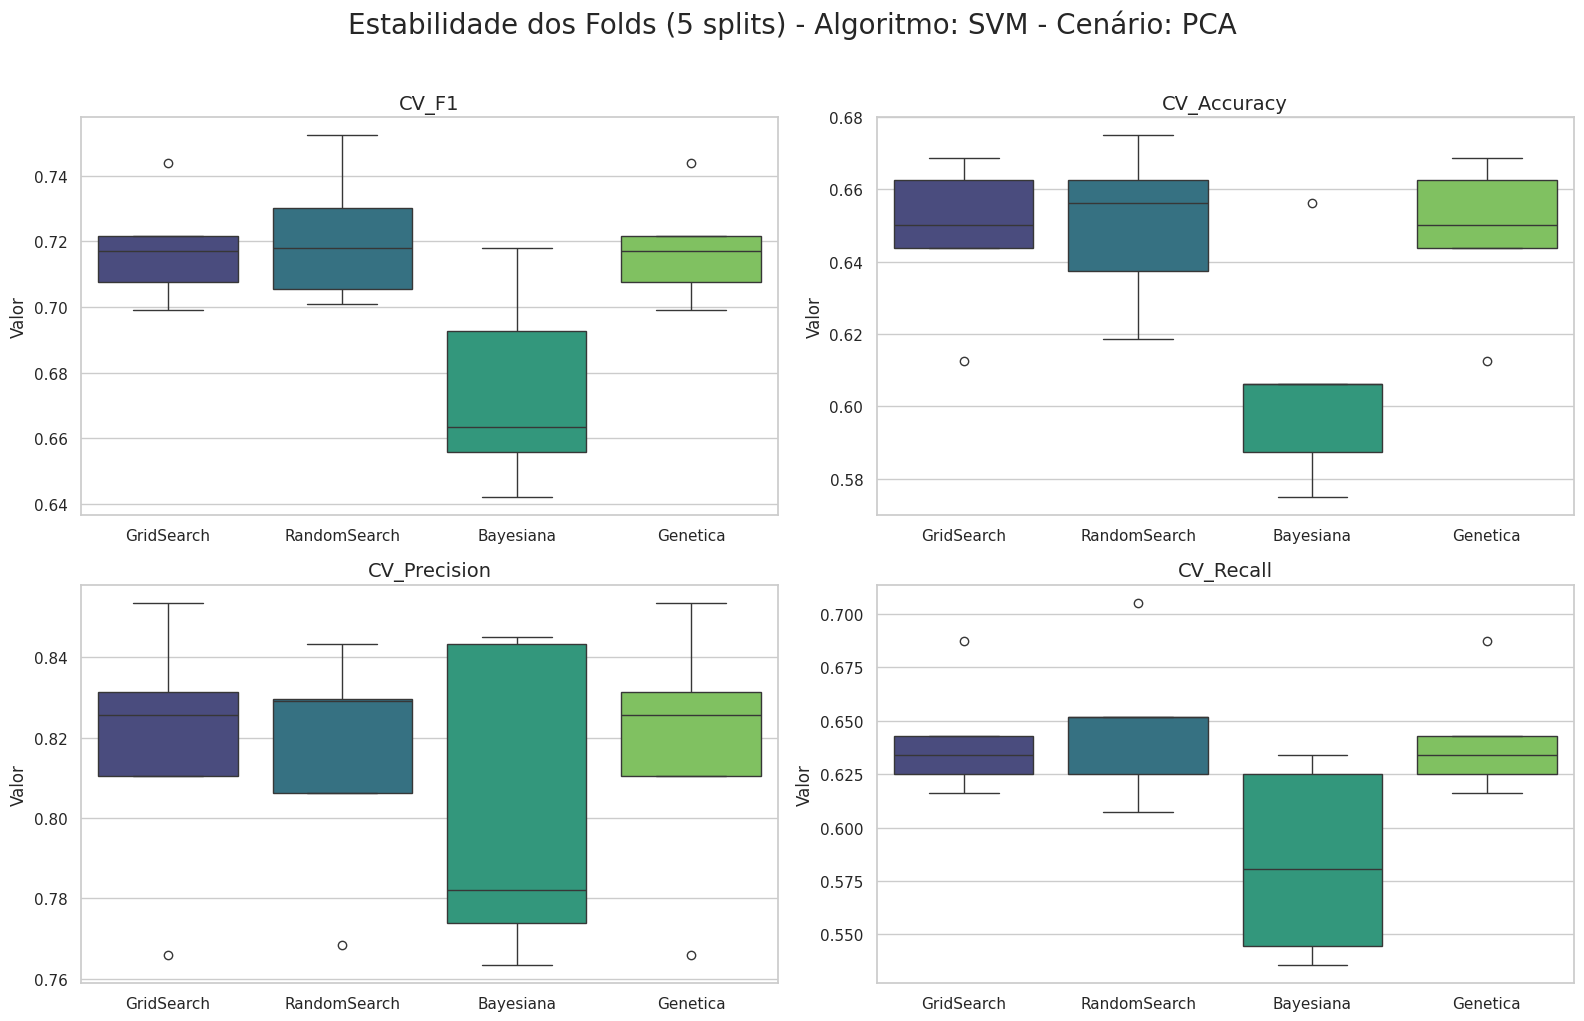

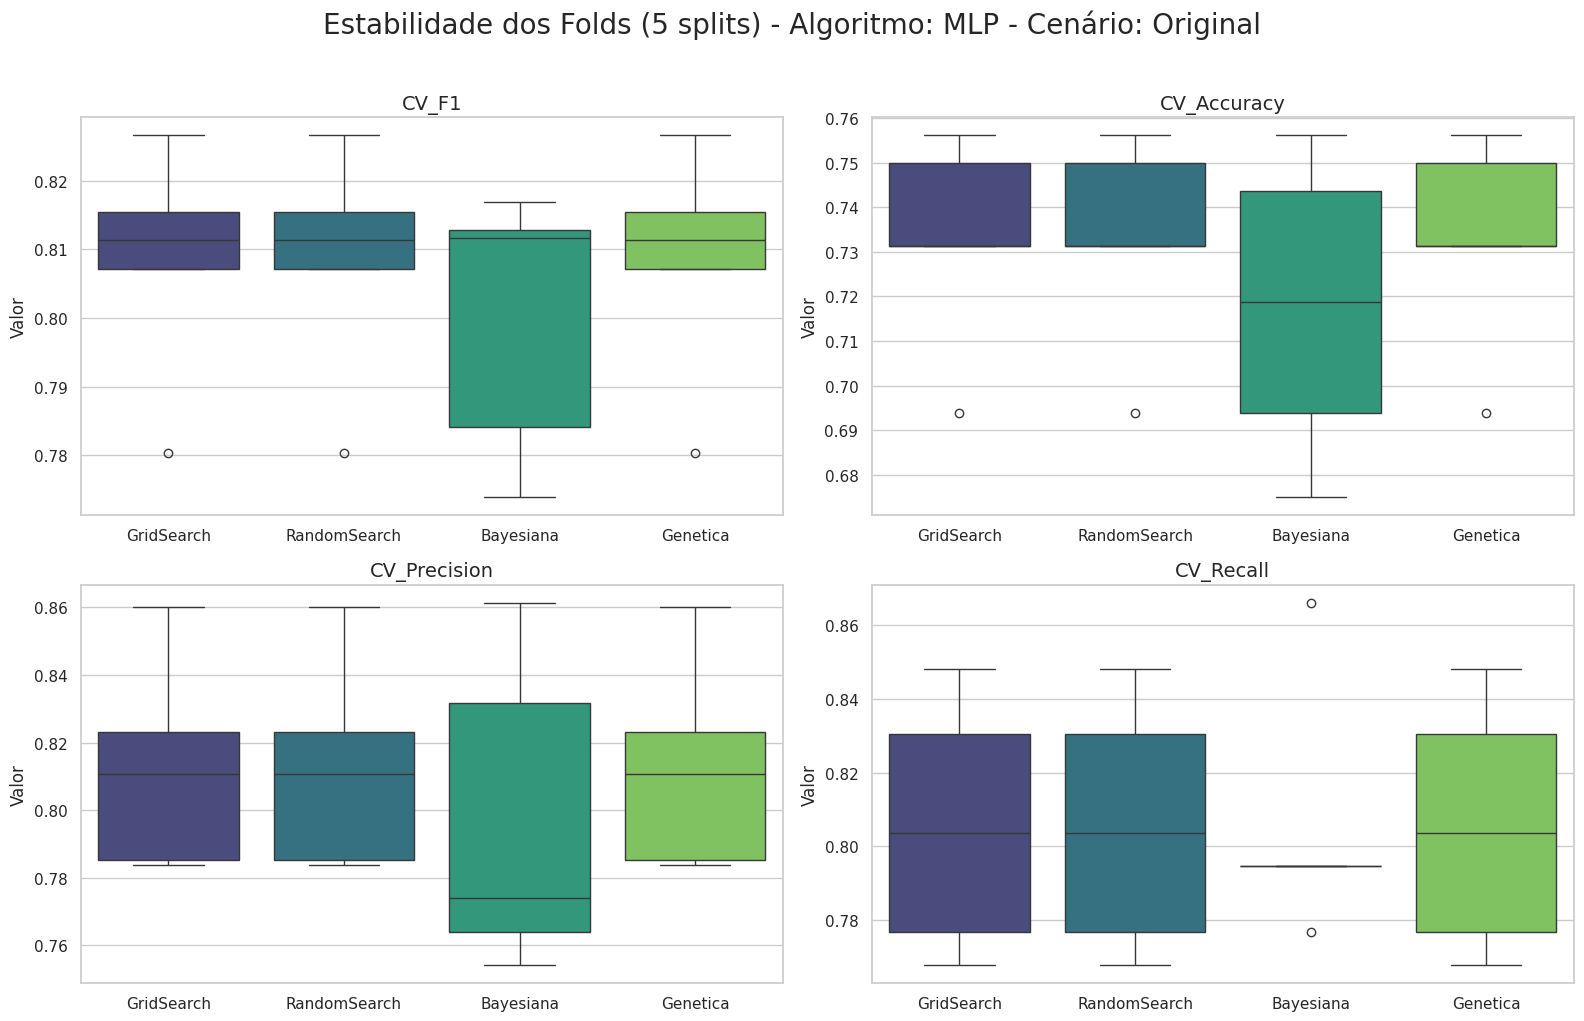

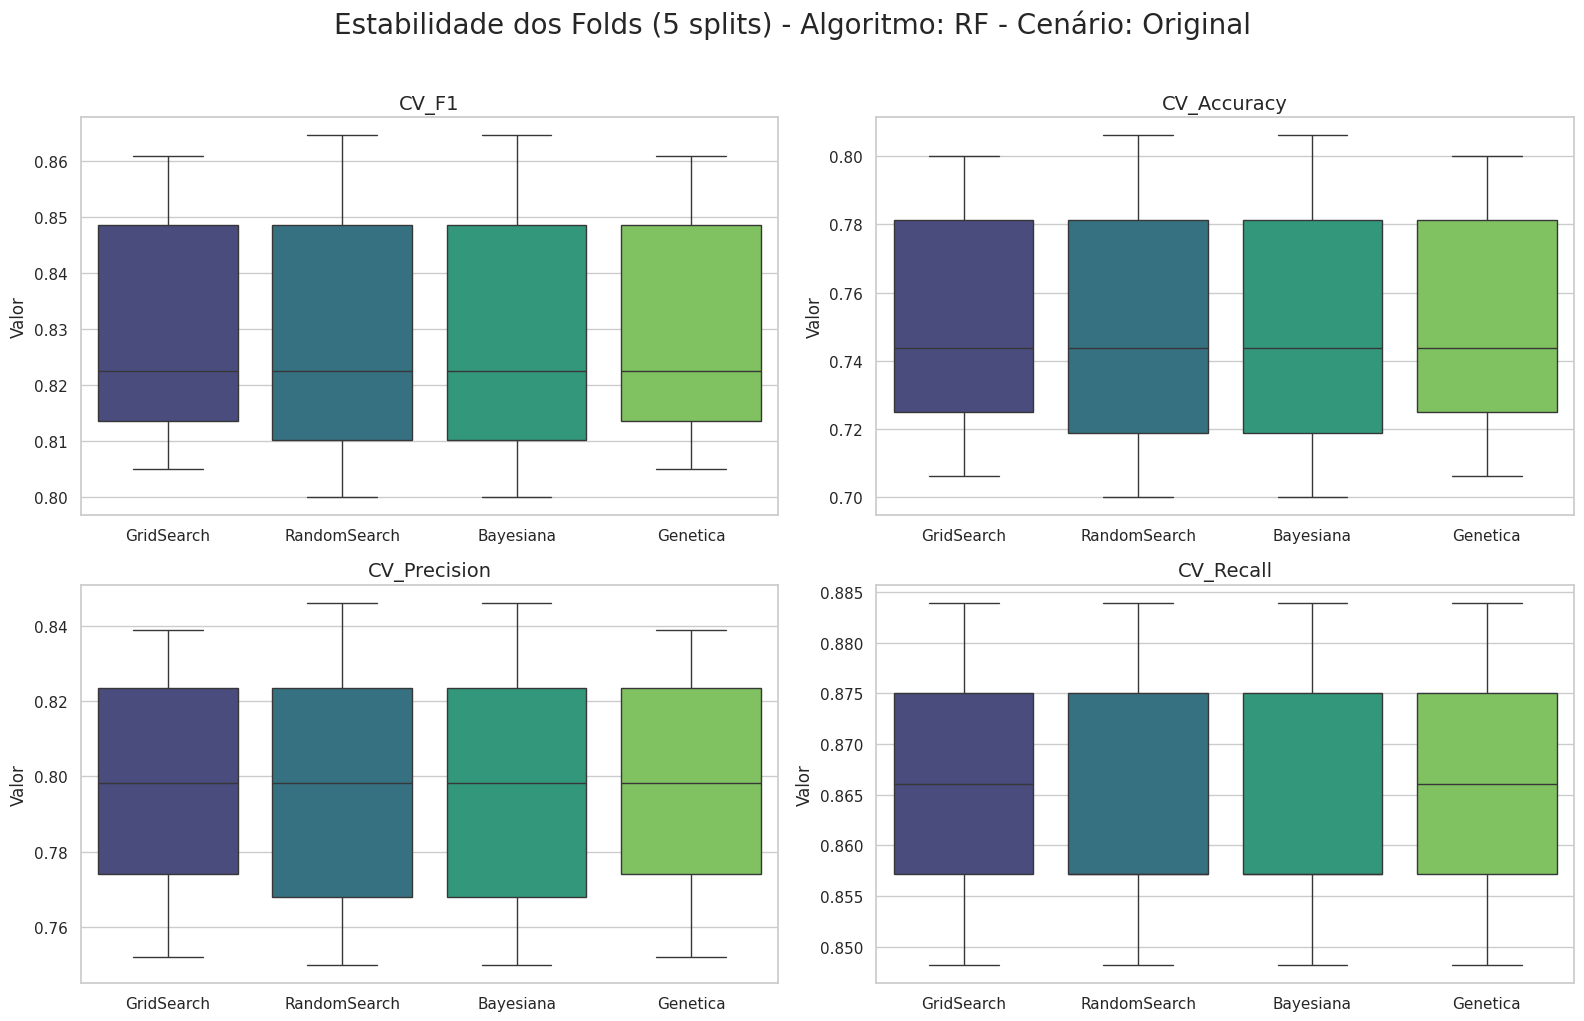

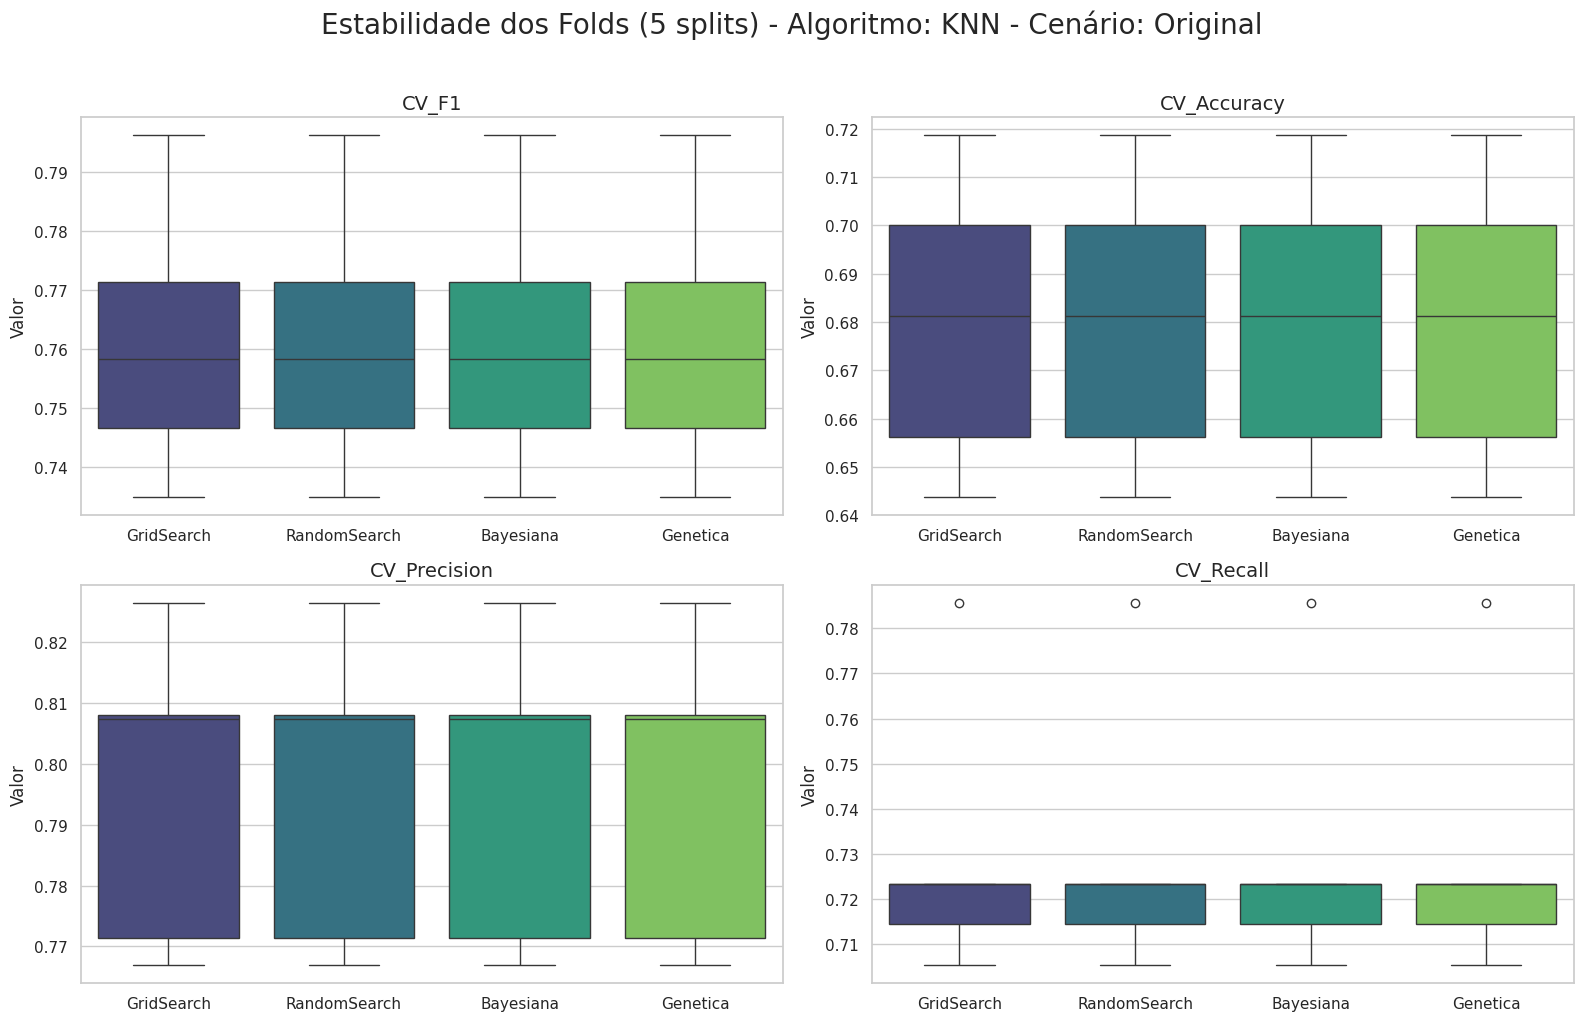

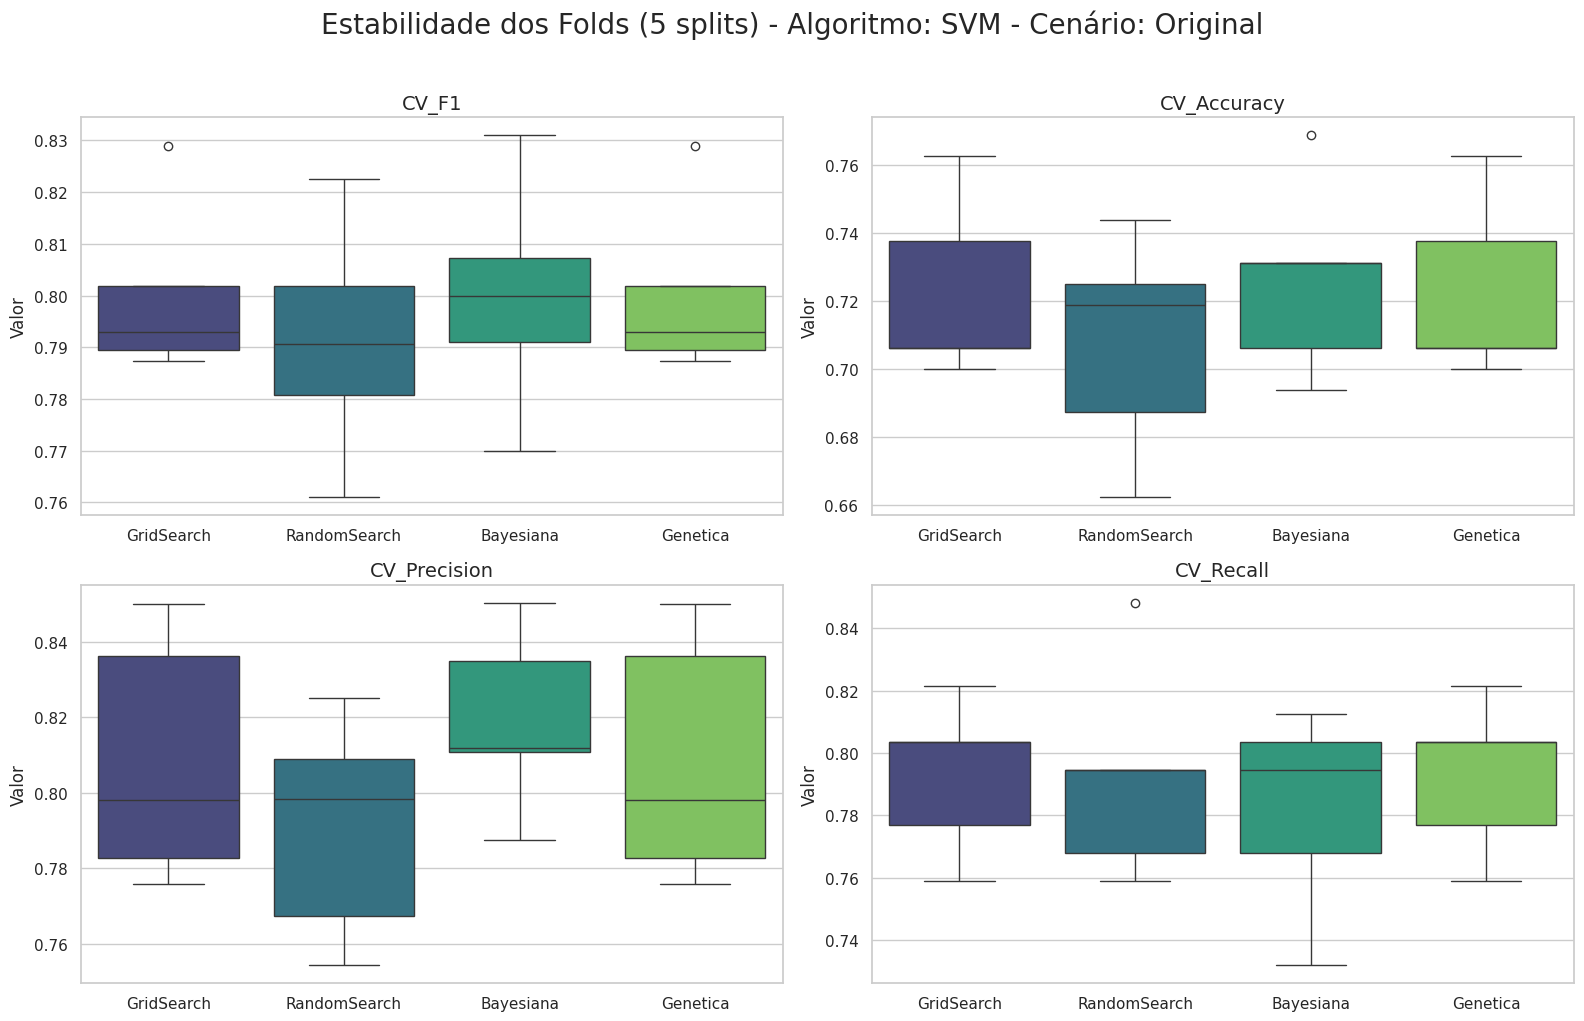

In [26]:
for categoria in df_resultados_resumo['Cenario'].unique():
    df_cenario = df_resultados_folds[df_resultados_folds['Cenario'] == categoria]
    
    for algoritmo in df_resultados_resumo['Algoritmo'].unique():
        df_alg = df_cenario[df_cenario['Algoritmo'] == algoritmo]
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        axes = axes.flatten()
        tipos_metricas = ['CV_F1', 'CV_Accuracy', 'CV_Precision', 'CV_Recall']
        
        for i, metrica in enumerate(tipos_metricas):
            sns.boxplot(
                data=df_alg,
                x="Otimizador",      
                y=metrica,
                hue="Otimizador",   
                ax=axes[i],         
                palette="viridis",
                legend=False        
            )
            
            # Ajustes visuais de cada subplot
            axes[i].set_title(f"{metrica}", fontsize=14)
            axes[i].set_xlabel("") 
            axes[i].set_ylabel("Valor")

        plt.suptitle(f"Estabilidade dos Folds (5 splits) - Algoritmo: {algoritmo} - Cenário: {categoria}", fontsize=20, y=1.02)
        
        plt.tight_layout()
        plt.show()

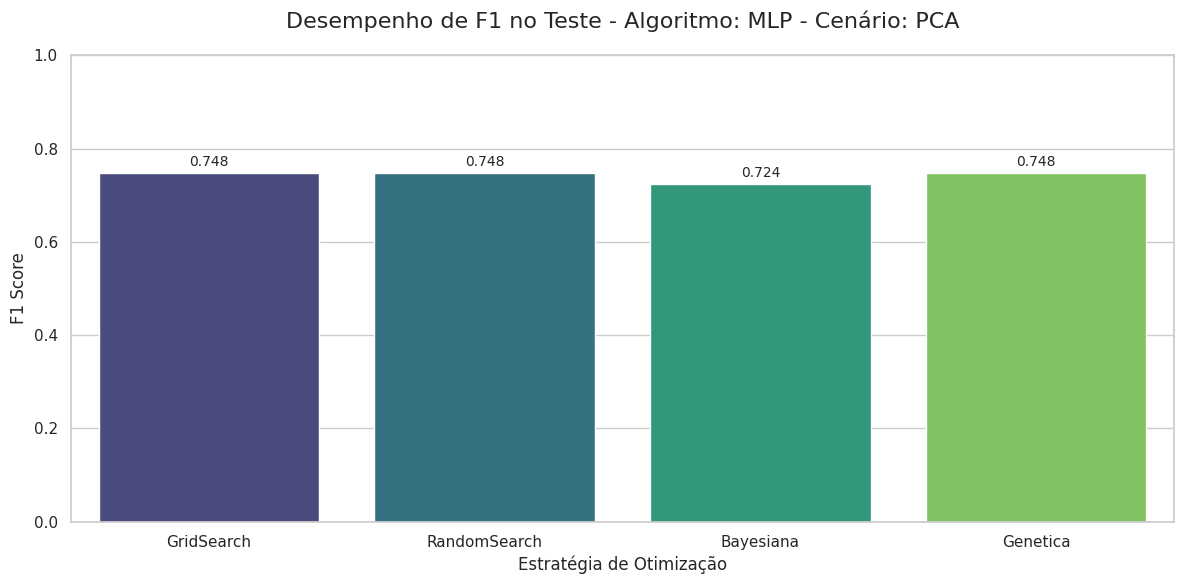

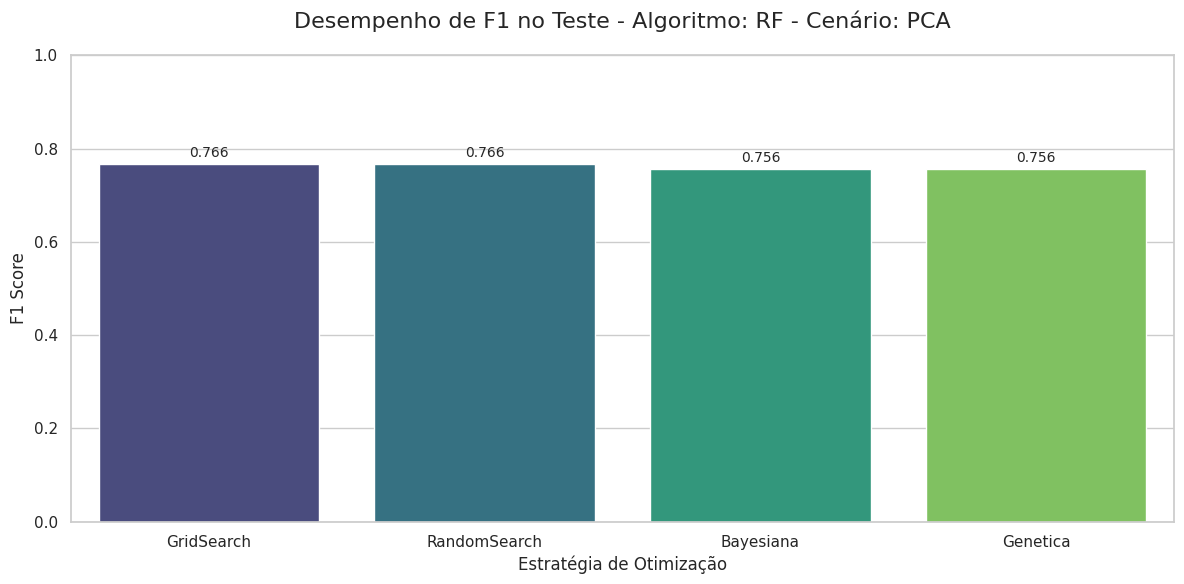

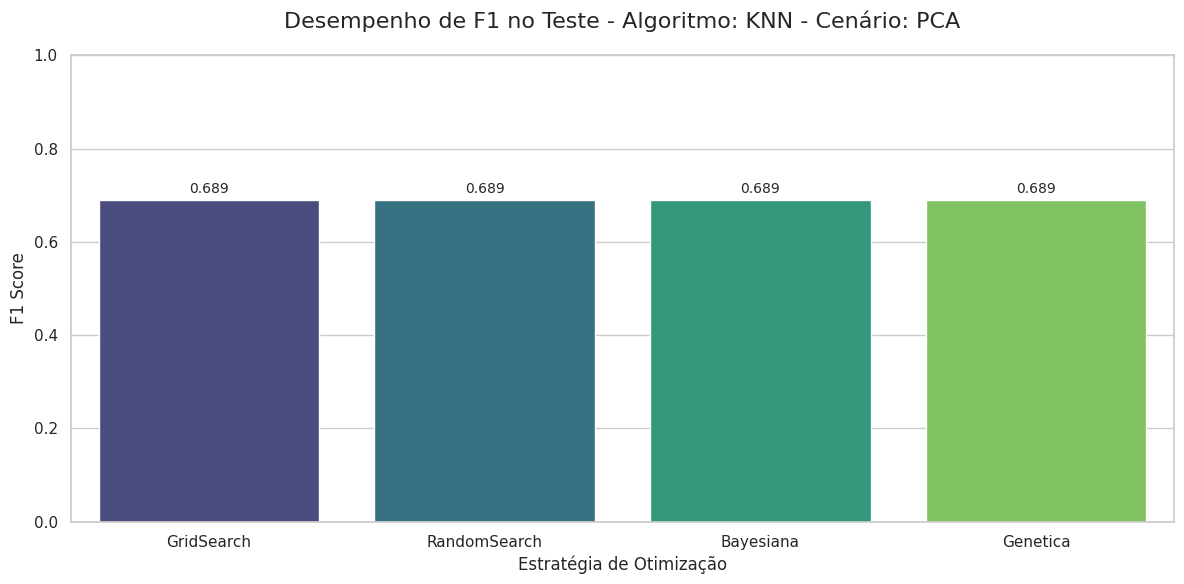

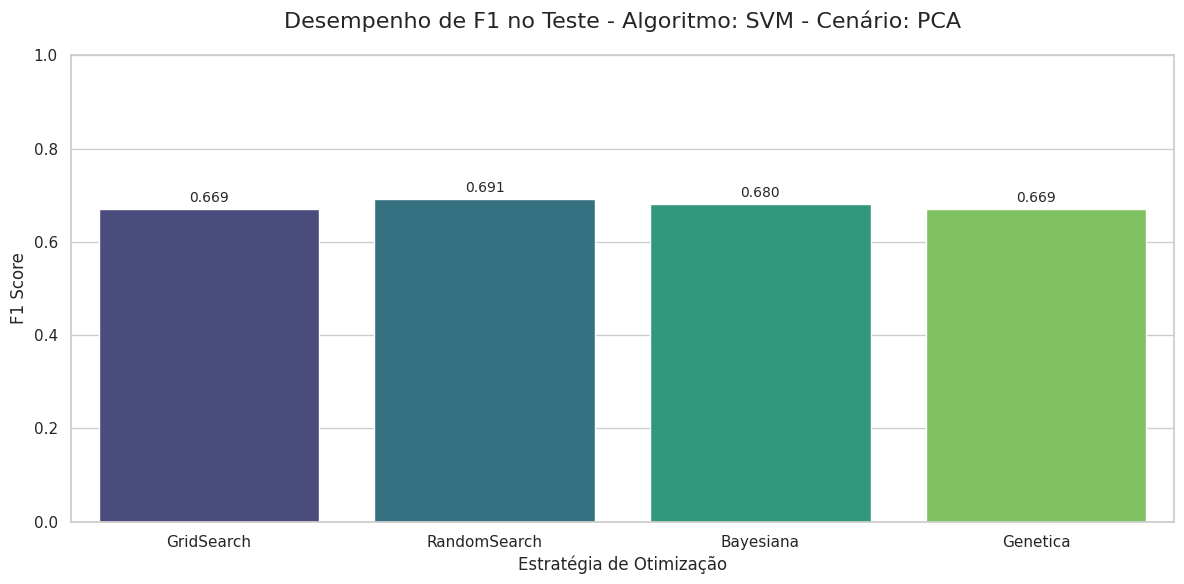

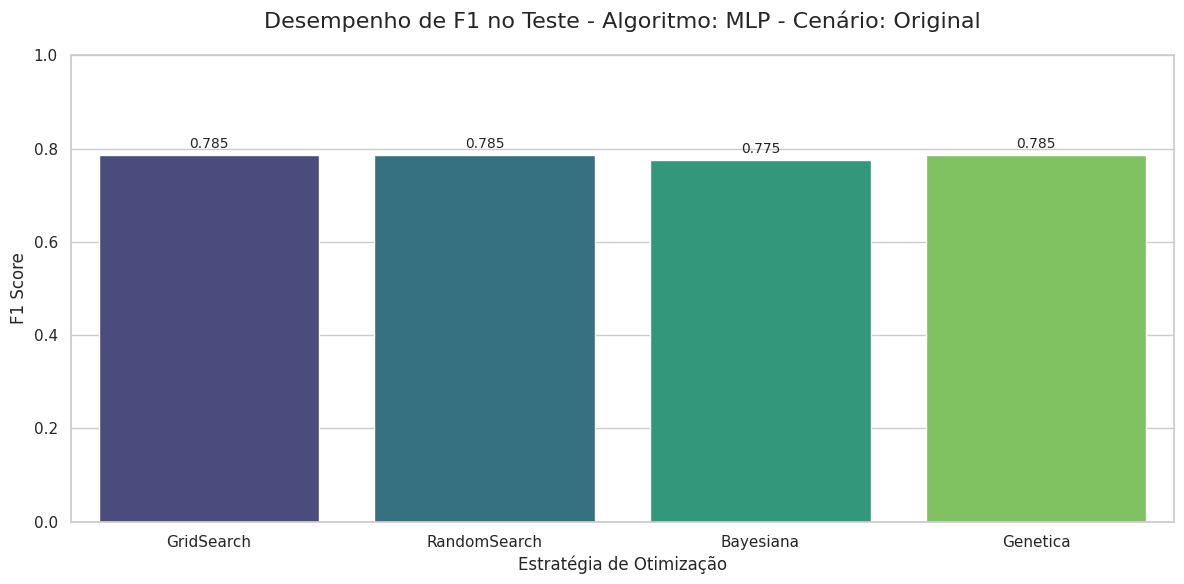

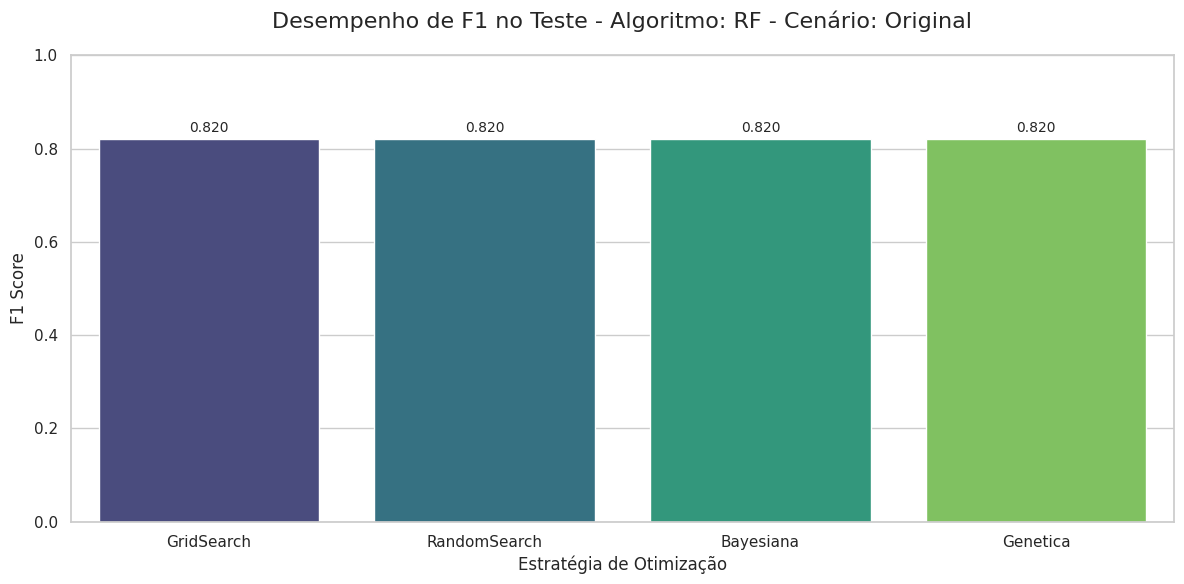

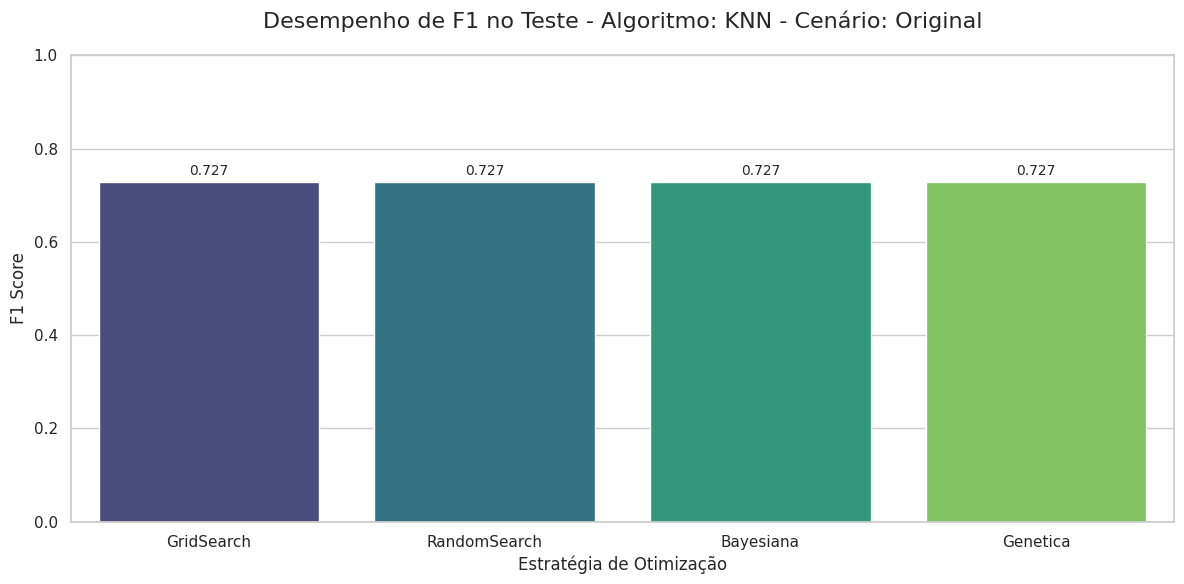

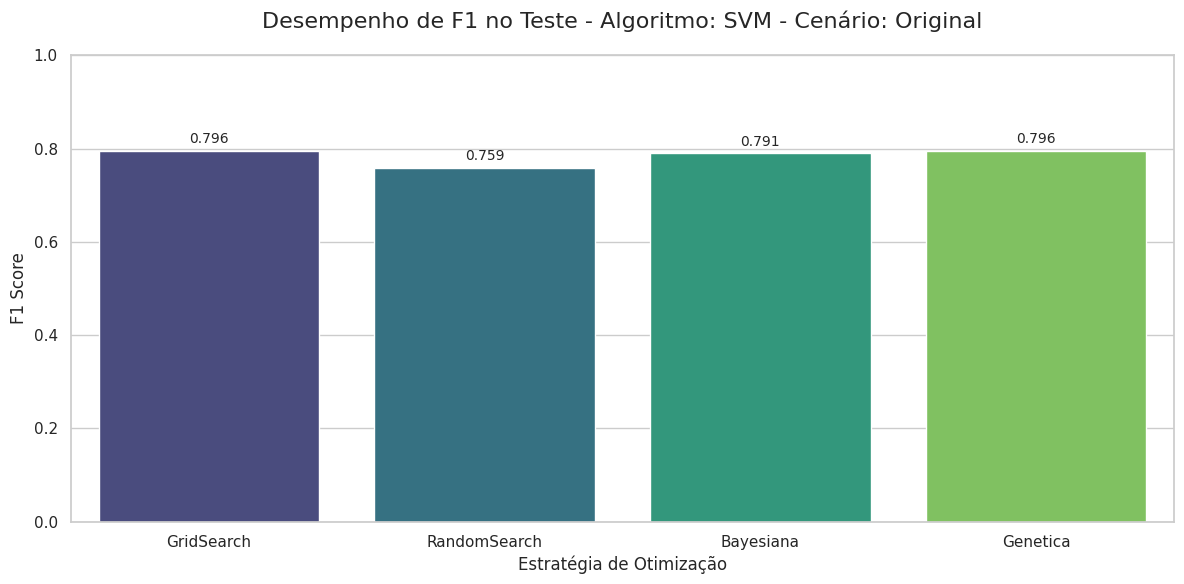

In [27]:
for categoria in df_resultados_resumo['Cenario'].unique():
    df_cenario = df_resultados_resumo[df_resultados_resumo['Cenario'] == categoria]
    
    for algoritmo in df_resultados_resumo['Algoritmo'].unique():
        plt.figure(figsize=(12, 6))
        df_plot = df_cenario[df_cenario['Algoritmo'] == algoritmo]
        
        ax = sns.barplot(
            data=df_plot,
            x="Otimizador",
            y="TEST_F1",
            hue="Otimizador", 
            palette="viridis"
        )

        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', padding=3, fontsize=10)

        plt.title(f"Desempenho de F1 no Teste - Algoritmo: {algoritmo} - Cenário: {categoria}", fontsize=16, pad=20)
        plt.ylabel("F1 Score")
        plt.xlabel("Estratégia de Otimização")
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()
        